In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy

# from tqdm import tqdm
import seaborn as sns

# load in bettor objects

from bettor import bettor, run_market, plot_returns, run_market_fixed_el, gen_election

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
colors = [
    "#CC99FF",  # lavender purple (existing)
    "#000080",  # navy blue (existing)
    "#339966",  # forest green (existing)
    "#F4A261",  # muted orange
    "#B22222",  # deep ruby red
    "#6A4C93",  # royal violet
    "#1D3557",  # dark indigo
    "#2A9D8F",  # teal
    "#457B9D",   # steel blue,
    "#FFB347",  # warm amber/orange
    "#E63946"  # deep crimson red
]

# define mpl colourmap
cmap= LinearSegmentedColormap.from_list("power_predictioncmap", colors)

In [5]:
from collections.abc import Iterable

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [6]:
def evaluate_markets(market_record, maxlag=5):
    mp = np.array(market_record['price_history'])
    tp = np.array(market_record['gen_el'])

    # take first differences
    tp_diff = np.diff(tp)
    mp_diff = np.diff(mp)
    ts_data = np.column_stack([mp_diff, tp_diff])

    mse = np.mean((mp-tp)**2)

    res = grangercausalitytests(ts_data, maxlag=maxlag, addconst=True, verbose=False)

    # pull p-values from one of the tests at each lag (e.g., ssr_ftest)
    pvals = {lag: res[lag][0]['ssr_ftest'][1] for lag in res}

    # decide significance at, say, 5%
    sig_lags = [lag for lag, p in pvals.items() if p < 0.05]
    # best_lag = min(sig_lags) if sig_lags else None

    # get lag with lowest p-value
    if pvals:
        best_lag = min(pvals, key=pvals.get)
    else:
        best_lag = None

    return mse, best_lag

In [9]:
# Global parameters

N_bettors = 100
T_max = 500
initial_price = 0.5
rw_variance = 0.05

### Market shock

In [10]:
n_iter_=100

In [11]:
# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


# expertise_values = np.linspace(0,1,N_bettors)

av_budget=100
budget_total = av_budget* N_bettors
N_whales = 1
whale_valuation = 0.6

prop_whale=0.5

expertise_whale = {}

for whale_valuation in [0.6,0.7,0.8]:
    
    whale_effect = []

    whale_budget = av_budget*N_bettors*prop_whale / (1-prop_whale)

    non_whale_bettors = [bettor(budget=av_budget, expertise=0.9) for i in range(N_bettors)]
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=whale_valuation) for _ in range(N_whales)]

    parameters.update({'bettors': non_whale_bettors + whale_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)

        whale_effect.append((np.array(market_record['price_history']) -  np.array(market_record['gen_el'])))

    expertise_whale[whale_valuation] = whale_effect

In [12]:
times = np.arange(T_max+1)
vals = []
for k,val in expertise_whale.items():
    for v in val:
        for x in range(T_max+1):
            vals.append([k,v[x],times[x]])


df_plot = pd.DataFrame(vals, columns = ['W','SE','T'])

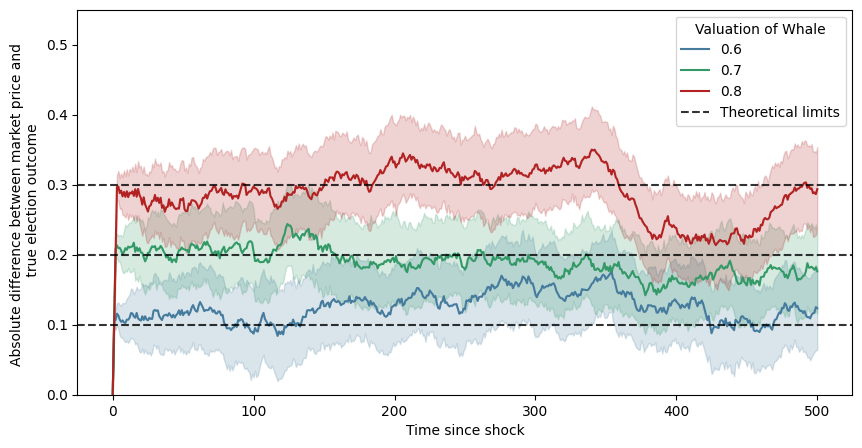

In [40]:
plt.figure(figsize=[10, 5])

sns.lineplot(data = df_plot, x='T', y='SE',hue='W', palette = ["#457B9D", "#339966", "#B22222"], linewidth=1.5)
plt.xlabel('Time since shock')

plt.ylabel('Absolute difference between market price and \n true election outcome')

# clip axhlines to max at 500
plt.axhline(0.2, color='black', linestyle='--', alpha=0.8)
plt.axhline(0.1, color='black', linestyle='--', alpha=0.8)
plt.axhline(0.3, color='black', linestyle='--', label='Theoretical limits', alpha=0.8)

# round labels in legend to 1dp
# get current legend
legend = plt.gca().get_legend()
for text in legend.get_texts():
    text.set_text(f"{float(text.get_text()):.1f}")

# move legend
plt.ylim(0,0.55)
plt.legend(title = 'Valuation of Whale', loc='upper right')

plt.savefig('TheoreticalAgreement.pdf', bbox_inches='tight')